In [ ]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from shutil import copyfile
from os import getcwd

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/data/train.zip" '.'

In [ ]:
!unzip -q train.zip 

In [ ]:
!rm train.zip

In [ ]:
print(len(os.listdir('./train')))

25000


In [ ]:
!mv train train_all

In [ ]:
base_dir = './'
train_dir = os.makedirs(os.path.join(base_dir, 'train'))
validation_dir = os.makedirs(os.path.join(base_dir, 'validation'))

# Directory with our training cat pictures
train_cats_dir = os.makedirs('./train/cats')

# Directory with our training dog pictures
train_dogs_dir = os.makedirs('./train/dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.makedirs('./validation/cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.makedirs('./validation/dogs')

In [ ]:
TRAIN_SOURCE = "./train_all/"
TRAINING_CATS_DIR = "./train/cats/"
TRAINING_DOGS_DIR = "./train/dogs/"
VAL_CATS_DIR = "./validation/cats/"
VAL_DOGS_DIR = "./validation/dogs/"
SPLIT_SIZE = 0.8

list_images = os.listdir(TRAIN_SOURCE)
print(len(list_images))
files = []
for file_name in list_images:
    if(os.path.getsize(TRAIN_SOURCE + file_name)) > 0:
        files.append(file_name)
    else:
        print(file_name + "has zero length!")
        
files = random.sample(files, len(files))
train_set = files[0:round(SPLIT_SIZE*len(files))]
val_set = files[-(len(files) - len(train_set)):]
print("Train-set size:", len(train_set))
print("Validation-set size:", len(val_set))
for file_name in train_set:
    if('cat' in file_name):        
        copyfile(TRAIN_SOURCE + file_name, TRAINING_CATS_DIR + file_name)
    elif('dog' in file_name):
        copyfile(TRAIN_SOURCE + file_name, TRAINING_DOGS_DIR + file_name)
for file_name in val_set:
    if('cat' in file_name):        
        copyfile(TRAIN_SOURCE + file_name, VAL_CATS_DIR + file_name)
    elif('dog' in file_name):
        copyfile(TRAIN_SOURCE + file_name, VAL_DOGS_DIR + file_name)

25001
Train-set size: 20001
Validation-set size: 5000


In [ ]:
# EarlyStopping and Reduce Learning Rate Callbacks
my_callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
my_callback_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.5, min_lr=0.00001, verbose=1)

model = tf.keras.models.Sequential([
    #Conv layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(132, 132, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    
])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 130, 130, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 64)       256       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
TRAINING_DIR = "./train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    target_size=(132, 132))

VALIDATION_DIR =  "./validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size=16,
                                                             class_mode='binary',
                                                             target_size=(132, 132))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_set) // 16,
    epochs = 25,
    verbose = 1,
    validation_data = train_generator,
    validation_steps = len(val_set) // 16,
    callbacks=[my_callback_es, my_callback_rlr]
)

Epoch 1/25
1250/1250 [==============================] - 1164s 931ms/step - loss: 0.6089 - acc: 0.7329 - val_loss: 0.6704 - val_acc: 0.6955 - lr: 0.0010
Epoch 2/25
1250/1250 [==============================] - 1167s 934ms/step - loss: 0.5528 - acc: 0.7706 - val_loss: 0.5927 - val_acc: 0.7650 - lr: 0.0010
Epoch 3/25
1250/1250 [==============================] - 1170s 936ms/step - loss: 0.5049 - acc: 0.8013 - val_loss: 0.4186 - val_acc: 0.8401 - lr: 0.0010
Epoch 4/25
1250/1250 [==============================] - 1170s 936ms/step - loss: 0.4645 - acc: 0.8171 - val_loss: 1.9502 - val_acc: 0.5441 - lr: 0.0010
Epoch 5/25
1250/1250 [==============================] - ETA: 0s - loss: 0.4444 - acc: 0.8255
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 [==============================] - 1176s 941ms/step - loss: 0.4444 - acc: 0.8255 - val_loss: 0.4307 - val_acc: 0.8163 - lr: 0.0010
Epoch 6/25
1250/1250 [==============================] - 1171s 936ms/step - loss: 0

In [ ]:
model.save_weights('Dense1024_Dropout_model_wieghts.h5')
model.save('Dense1024_Dropout_model_keras.h5')
model_json = model.to_json()
with open("./model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
!cp "./Dense1024_Dropout_model_wieghts.h5" "/content/drive/MyDrive/data"
!cp "./Dense1024_Dropout_model_keras.h5" "/content/drive/MyDrive/data"
!cp "./model.json" "/content/drive/MyDrive/data"

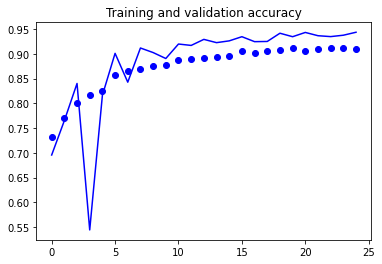

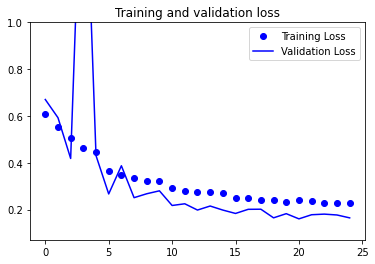

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim(top=1.0)
plt.title('Training and validation loss')
plt.legend()

plt.show()